### Machine Learning with Big Data
## Part 1: Fully Connected Layers

# 0.2 - baseline mlp

**Group:** MLBD_Deventer 4
**Students:** Mathijs Pattipeilohy (512391), Emin Fikret (511275)

## gpu and performance setup
this part sets up tensorflow to run faster using your gpu:

enables xla (accelerated linear algebra) which makes tensorflow optimize computations internally

turns on mixed precision, letting the gpu use 16-bit floats where possible (saves memory and increases speed)

allows tf32 math for faster gpu matrix operations on newer nvidia cards

sets gpu memory growth so tensorflow doesn’t reserve all gpu memory at once, it grows as needed

in short: this block makes training faster and more efficient without changing model accuracy

In [25]:
# setup and speed
# enable xla mixed precision and gpu memory growth

import os
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/opt/cuda'

import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import mixed_precision

tf.config.optimizer.set_jit(True)
try:
    tf.config.experimental.enable_tensor_float_32_execution(True)
except:
    pass

mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('gpu detected', gpus[0])
    except:
        pass
else:
    print('no gpu detected running on cpu')


gpu detected PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Load metadata and data
use balanced train data and raw validation data

In [26]:
with open('../artifacts/metadata.json') as f:
    meta = json.load(f)

x_train_path = '../artifacts/X_train_balanced.npy' if os.path.exists('../artifacts/X_train_balanced.npy') else '../artifacts/X_train.npy'
y_train_path = '../artifacts/y_train_balanced.npy' if os.path.exists('../artifacts/y_train_balanced.npy') else '../artifacts/y_train.npy'

X_train = np.load(x_train_path)
X_val   = np.load('../artifacts/X_val.npy')
y_train = np.load(y_train_path)
y_val   = np.load('../artifacts/y_val.npy')

num_classes = len(meta['label_classes'])
y_train_oh = keras.utils.to_categorical(y_train, num_classes)
y_val_oh   = keras.utils.to_categorical(y_val,   num_classes)


## dataset optimization and batching
this part prepares the training and validation data for tensorflow in an efficient way:

converts the input arrays to float16 to save gpu memory (since we’re using mixed precision)

sets up tensorflow datasets (train_ds and val_ds) that stream data efficiently during training

cache() keeps data in memory after the first read for faster access

shuffle(10000) randomizes the training data order each epoch to prevent pattern bias

batch(BATCH) groups samples into batches of 1024 for parallel processing

prefetch(tf.data.AUTOTUNE) overlaps data loading with gpu computation for speed

overall, this makes the data pipeline fast, memory-efficient, and well-optimized for training

In [27]:
X_train = X_train.astype('float16', copy=False)
X_val   = X_val.astype('float16', copy=False)

BATCH = 1024
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_oh)).cache().shuffle(10000).batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val,   y_val_oh)).cache().batch(BATCH).prefetch(tf.data.AUTOTUNE)

## Build model
simple mlp with one hidden layer relu and dropout

In [28]:


inp = keras.Input(shape=(X_train.shape[1],))
x = keras.layers.Dense(64, activation='relu')(inp)
x = keras.layers.Dropout(0.2)(x)
out = keras.layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
model = keras.Model(inp, out)


## Compile and train
this part defines how the model learns and starts the actual training:

uses categorical crossentropy as the loss function since we’re doing multi-class classification

tracks accuracy to measure how often the model predicts the correct class

enables jit_compile=True for just-in-time optimization with xla for extra speed

then model.fit() trains the model for 30 epochs,
using the prepared datasets for training and validation while recording progress in history

In [29]:
opt = keras.optimizers.legacy.Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], jit_compile=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    verbose=1
)


Epoch 1/30
20/20 [==============================] - 1s 45ms/step - loss: 2.2884 - accuracy: 0.1246 - val_loss: 2.2032 - val_accuracy: 0.2216
Epoch 2/30
20/20 [==============================] - 0s 10ms/step - loss: 2.0923 - accuracy: 0.3165 - val_loss: 2.1443 - val_accuracy: 0.2463
Epoch 3/30
20/20 [==============================] - 0s 7ms/step - loss: 1.9109 - accuracy: 0.4100 - val_loss: 2.0716 - val_accuracy: 0.2670
Epoch 4/30
20/20 [==============================] - 0s 8ms/step - loss: 1.7333 - accuracy: 0.4557 - val_loss: 1.9688 - val_accuracy: 0.2994
Epoch 5/30
20/20 [==============================] - 0s 10ms/step - loss: 1.5683 - accuracy: 0.5058 - val_loss: 1.8684 - val_accuracy: 0.3204
Epoch 6/30
20/20 [==============================] - 0s 9ms/step - loss: 1.4308 - accuracy: 0.5401 - val_loss: 1.7891 - val_accuracy: 0.3392
Epoch 7/30
20/20 [==============================] - 0s 9ms/step - loss: 1.3174 - accuracy: 0.5677 - val_loss: 1.7193 - val_accuracy: 0.3423
Epoch 8/30
20/20 

## Plot curves
save loss and accuracy figures

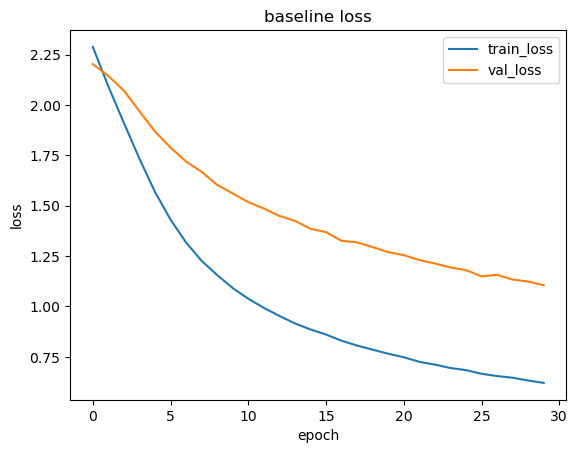

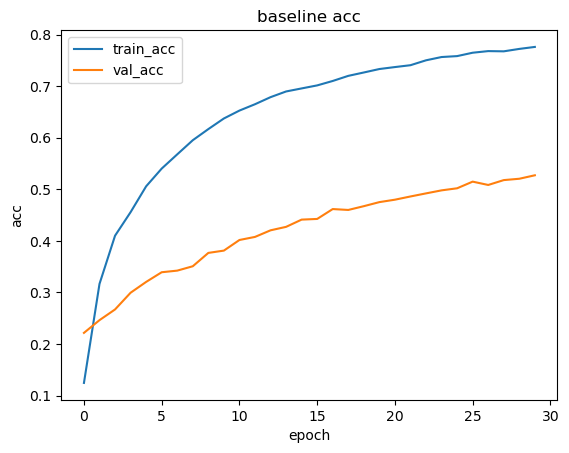

In [30]:
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.title('baseline loss')
plt.savefig('../artifacts/baseline_loss.png', dpi=150)

plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('epoch'); plt.ylabel('acc'); plt.legend(); plt.title('baseline acc')
plt.savefig('../artifacts/baseline_acc.png', dpi=150)


In [31]:
# export keras model and training history json
model.save('../artifacts/baseline_model.keras')
with open('../artifacts/baseline_history.json','w') as f:
    json.dump(history.history, f)